# Cloning the repo to read the required data such as images and videos

In [ ]:
!git clone https://github.com/FadyGamilM/Advanced-Lane-Detetction-phase-1

fatal: destination path 'Advanced-Lane-Detetction-phase-1' already exists and is not an empty directory.


# Import Essential Libraries

In [ ]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from docopt import docopt
from moviepy.editor import VideoFileClip
import glob
from google.colab.patches import cv2_imshow

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3096576/45929032 bytes (6.7%)6258688/45929032 bytes (13.6%)9527296/45929032 bytes (20.7%)12828672/45929032 bytes (27.9%)16007168/45929032 bytes (34.9%)19283968/45929032 bytes (42.0%)22577152/45929032 bytes (49.2%)25780224/45929032 bytes (56.1%)28655616/45929032 bytes (62.4%)32022528/45929032 bytes (69.7%)35233792/45929032 bytes (76.7%)38526976/45929032 bytes (83.9%)

#**(1) Calibrate the camera and remove the distortion**
---

## Camera Calibration

In [ ]:
def calibrate_camera():
  """ 
  Calibrate the camera using list of calibration images and return the camera matrix 
  and distortion coeff which we need to undistord the input frame using `cv2.undistort()`
  """
  # 9 intersections in x-axis and 6 intersections in y-axis
  nx = 9
  ny = 6
  objpoints = []
  imgpoints = []
  # create matrix with size of all corners with 3 dim
  objp = np.zeros((nx*ny, 3), np.float32)
  objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

  # Make a list of calibration images
  frames = glob.glob('/content/Advanced-Lane-Detetction-phase-1/camera_cal/calibration*.jpg')
  # loop through the frames paths
  for frame in frames:
    # read the frame using the given path
    img = mpimg.imread(frame)
    # calibration_img_BGR = cv2.imread(frame)
    # calibration_img_RGB = cv2.cvtColor(calibration_img_BGR, cv2.COLOR_BGR2RGB)
    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(img, (nx, ny))
    if ret:
      imgpoints.append(corners)
      objpoints.append(objp)

  shape = (img.shape[1], img.shape[0])
  ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
  return mtx, dist

camera_Matrix, distortion_Coeff = calibrate_camera() 

## Undistortion

In [ ]:
def undistort(test_frame):
  """ 
    # Method number 1 in pipeline of the main function ...
    this method remove the distortion from the image using the camera matrix and distortion coeff
  """
  return cv2.undistort(test_frame, camera_Matrix, distortion_Coeff, None, camera_Matrix)

## Testing Camera Calibration and Distortion Removal Step

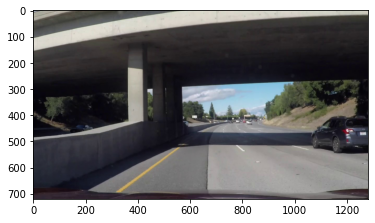

In [ ]:
test_original_image = mpimg.imread('/content/Advanced-Lane-Detetction-phase-1/test_images/challenge_video_frame_120.jpg')
plt.imshow(test_original_image)

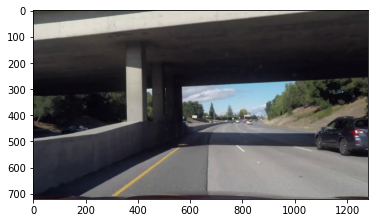

In [ ]:
test_undistorted_image = undistort(test_original_image)
plt.imshow(test_undistorted_image)

#**(2) Finding Top (Eye-bird) view from Front-view**
---

In [ ]:
src = np.float32([(550, 460),     # top-left
                  (150, 720),     # bottom-left
                  (1200, 720),    # bottom-right
                  (770, 460)])    # top-right
dst = np.float32([(100, 0),
                  (100, 720),
                  (1100, 720),
                  (1100, 0)])

In [ ]:
def get_transform_matrix(src, dst):
  """ get the transform matrix from src and dst dimensions """
  M = cv2.getPerspectiveTransform(src, dst)
  return M

def get_inverse_transform_matrix(src, dst):
  """ get the inverse transform matrix from src and dst dimensions """
  M_inv = cv2.getPerspectiveTransform(dst, src)
  return M_inv

In [ ]:
# get the transform and inverse transform matrix
transform_matrix = get_transform_matrix(src, dst)
inverse_transform_matrix = get_inverse_transform_matrix(src, dst)

In [ ]:
def get_eye_bird_view(img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
  """ 
  Take a front view image and transform to top view
  Parameters:
      img (np.array): A front view image
      img_size (tuple): Size of the image (width, height)
      flags : flag to use in cv2.warpPerspective()

  Returns:
      Image (np.array): Top view image
  """
  return cv2.warpPerspective(img, transform_matrix, img_size, flags=flags)

In [ ]:
def get_front_view(img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
  """ Take a top view image and transform it to front view

  Parameters:
      img (np.array): A top view image
      img_size (tuple): Size of the image (width, height)
      flags (int): flag to use in cv2.warpPerspective()

  Returns:
      Image (np.array): Front view image
  """
  return cv2.warpPerspective(img, inverse_transform_matrix, img_size, flags=flags)


## Testing the Prespective Transform step 

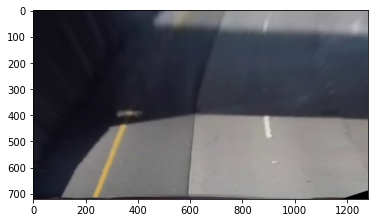

In [ ]:
test_eye_bird_view_image = get_eye_bird_view(test_undistorted_image)
plt.imshow(test_eye_bird_view_image)

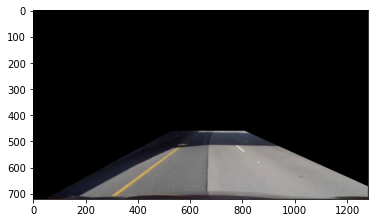

In [ ]:
test_front_view_from_eye_bird_view_image = get_front_view(test_eye_bird_view_image)
plt.imshow(test_front_view_from_eye_bird_view_image)

#**(3) Thresholding**
---

In [ ]:
def threshold_rel(img, lo, hi):
  vmin = np.min(img)
  # print("vmin = ", vmin)
  vmax = np.max(img)
  # print("vmax = ", vmax)
  vlo = vmin + (vmax - vmin) * lo
  # print("vlo = ", vlo)
  vhi = vmin + (vmax - vmin) * hi
  # print("vhi = ", vhi)
  # print(np.uint8((img >= vlo) & (img <= vhi)) * 255)
  return np.uint8((img >= vlo) & (img <= vhi)) * 255

def threshold_abs(img, lo, hi):
  # print(np.uint8((img >= lo) & (img <= hi)) * 255)
  return np.uint8((img >= lo) & (img <= hi)) * 255

In [ ]:
def thresholding(img):
  """ Take an image and extract all relavant pixels.

  Parameters:
      img (np.array): Input image

  Returns:
      binary (np.array): A binary image represent all positions of relavant pixels.
  """
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  # Lets now extract the channels we need from the hls and hsv color spaces
  h_channel = hls[:,:,0]
  l_channel = hls[:,:,1]
  s_channel = hls[:,:,2]
  v_channel = hsv[:,:,2]
  # we choosed the L-channel to detect the right lane because the right lane is almost white
  # so we put the min threshold to 80% and max threshold to be 100%
  right_lane = threshold_rel(l_channel, 0.8, 1.0)
  right_lane[:,:750] = 0
  # print("right_lane", right_lane)
  # choose the range from 30*(2/3) = 20 and 60*(2/3) = 40 but we will take the range from 20 to 30 only because the dark yellow is not in our case
  left_lane = threshold_abs(h_channel, 20, 30)
  # the value of the color is from 70 % to 100 % in intensity
  left_lane &= threshold_rel(v_channel, 0.7, 1.0)
  left_lane[:,550:] = 0
  img2 = left_lane | right_lane
  return img2

## Testing the Thresholding step

(720, 1280, 3)


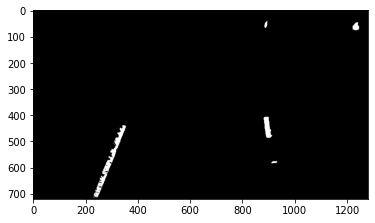

In [ ]:
test_thresholded_image = thresholding(test_eye_bird_view_image)
test_thresholded_image_cpy = np.copy(test_thresholded_image)
test_thresholded_image_cpy = np.dstack((test_thresholded_image_cpy, test_thresholded_image_cpy, test_thresholded_image_cpy))
print(test_thresholded_image_cpy.shape)
plt.imshow(test_thresholded_image_cpy)


# print(test_thresholded_image_cpy.reshape((test_thresholded_image_cpy.shape[0], test_thresholded_image_cpy.shape[1], 3)).shape)
# converted_img = cv2.cvtColor(test_thresholded_image, cv2.COLOR_BGR2RGB)
# plt.imshow(converted_img)
# print(converted_img.shape)
# print(test_thresholded_image.shape)
# plt.imshow(test_thresholded_image, cmap='gray')

# (4) Lane Lines Detection

* we will assume that we will have 9 windows per lane 
* the width of the window = 2 * margin 
* margin = 100
* the minimum number of pixels to recenter a single window is minpix , and minpix = 50

### detect_lane_lines Function

In [ ]:
def detect_lane_lines(img):
  """
  this method wrap the whole lane_lines_detection process by calling these 2 methods
  """
  # extract more features from the image .. 
  extract_features(img)
  # try to fit and draw the lane lines using polyfit technique
  return fit_poly(img)


### get_histogram ▶
 this function receives an image and retuns histogram representation

In [ ]:
def get_histogram(img):
  """ function that returns a histogram for a passed image """ 
  # take the bottom half of the image by taking all rows starting 
  # from the middle of the image to the bottom of the image
  # and take all the width
  bottom_half = img[img.shape[0]//2:,:]
  # return the sum of all the rows starting from the bottom half of the image
  return np.sum(bottom_half, axis=0)

### Required Variables

In [ ]:
nwindows = 9
margin = 100
minpix = 50
binary = None
left_fit = None
right_fit = None
dir = []
nonzero = None
nonzerox = None
nonzeroy = None
clear_visibility = True
window_height = 0

### Extract more features

In [ ]:
def extract_features(img):
  global nonzero
  global nonzerox
  global nonzeroy
  global window_height
  window_height = np.int(img.shape[0]//nwindows)
  # Identify the x and y positions of all nonzero pixel in the image
  nonzero = img.nonzero()
  # returns the nonzero from width (cols)
  nonzerox = np.array(nonzero[1])
  # returns the nonzero from height (rows)
  nonzeroy = np.array(nonzero[0])

we have 9 windows per lane, and we have the height of the lane which is equale the height of the eye-bird image .. so we can calculate the height of a single window

### pixels_in_window ▶
 returns all pixels that in a specific window

In [ ]:
def pixels_in_window(center, margin, height):
  global nonzerox
  global nonzeroy
  """ Return all pixel that in a specific window

  Parameters:
      center (tuple): coordinate of the center of the window
      margin (int): half width of the window
      height (int): height of the window

  Returns:
      pixelx (np.array): x coordinates of pixels that lie inside the window
      pixely (np.array): y coordinates of pixels that lie inside the window
  """
  topleft = (center[0]-margin, center[1]-height//2)
  bottomright = (center[0]+margin, center[1]+height//2)

  condx = (topleft[0] <= nonzerox) & (nonzerox <= bottomright[0])
  condy = (topleft[1] <= nonzeroy) & (nonzeroy <= bottomright[1])
  return nonzerox[condx&condy], nonzeroy[condx&condy]

<!-- ![pixels_in_window](window)

### find_lane_pixels(img) ▶
find all pixels of the lane by getting the all non-zero pixels on each window and add them all together, same for the right lane 

In [ ]:
def find_lane_pixels(img):
  """
  this function find the x,y coordinates of all pixels in left lane
  and also find the x,y coordinates of all pixels in right lane
  returns:
    > leftx
    > rightx
    > lefty
    >righty
  """
  global window_height
  global nwindows
  global margin
  global minpix

  assert(len(img.shape) == 2)
  # Create an output image to draw on and visualize the result
  out_img = np.dstack((img, img, img)) # convert from 2d to 3d image

  # get the histogram of the image
  histogram = get_histogram(img)
  # get the mid point of this histogram
  midpoint = histogram.shape[0]//2
  # divide the histogram to 2 parts 
  # -> getting the max index of max point from starting point of the histogram to the midpoint
  leftx_base = np.argmax(histogram[:midpoint])
  # -> the max index of max point from midpoint to the end of histogram
  rightx_base = np.argmax(histogram[midpoint:]) + midpoint

  # lets now store the left_base and right_base into new variables to update them without any errors
  leftx_current = leftx_base
  rightx_current = rightx_base

  # initially we are above the height of the image by 0.5 window height  = 370 "350 + 20" window_height = 40
  y_current = img.shape[0] + window_height//2

  # Create empty lists to reveice left and right lane pixel
  leftx, lefty, rightx, righty = [], [], [], []

  # Step through the windows one by one
  for _ in range(nwindows):
    # center of the current window (from top to bottom)
    y_current -= window_height
    # we are operating the left and right window in parallel,
    # we are starting from the center of the first window of left and right lanes starting from top to bottm
    center_left = (leftx_current, y_current)
    center_right = (rightx_current, y_current)

    good_left_x, good_left_y = pixels_in_window(center_left, margin, window_height)
    good_right_x, good_right_y = pixels_in_window(center_right, margin, window_height)

    # Append these indices to the lists
    leftx.extend(good_left_x)
    lefty.extend(good_left_y)
    rightx.extend(good_right_x)
    righty.extend(good_right_y)

    if len(good_left_x) > minpix:
        leftx_current = np.int32(np.mean(good_left_x))
    if len(good_right_x) > minpix:
        rightx_current = np.int32(np.mean(good_right_x))

  return leftx, lefty, rightx, righty, out_img



### we won't use the Hough transform to detect the lines because Hough transform works well with straight lines but we are dealing with curved lines, so we will use polyfit technique which fits the curved lines by mapping the given points with a polynomial from given degree "we will set the degree to be = 2" So, the poly will be `a X^2 + b X + c `


### fit_poly(img) ▶
 using fitpoly technique instead of hough transform as we mentioned

In [ ]:
def fit_poly(img):
  """Find the lane line from an image and draw it.

  Parameters:
      img (np.array): a binary warped image

  Returns:
      out_img (np.array): a RGB image that have lane line drawn on that.
  """
  global left_fit
  global right_fit

  # we have all pixels in each window in left and right lanes
  leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)

  if len(lefty) > 1500:
    left_fit = np.polyfit(lefty, leftx, 2) # 2nd degree polynomial 
    # print(left_fit)
  if len(righty) > 1500:
    right_fit = np.polyfit(righty, rightx, 2)

  # Generate x and y values for plotting
  maxy = img.shape[0] - 1
  miny = img.shape[0] // 3
  if len(lefty):
    maxy = max(maxy, np.max(lefty))
    miny = min(miny, np.min(lefty))

  if len(righty):
    maxy = max(maxy, np.max(righty))
    miny = min(miny, np.min(righty))

  ploty = np.linspace(miny, maxy, img.shape[0])

  left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
  right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

  # Visualization
  for i, y in enumerate(ploty):
    l = int(left_fitx[i])
    r = int(right_fitx[i])
    y = int(y)
    cv2.line(out_img, (l, y), (r, y), (0, 255, 0))

  lR, rR, pos = measure_curvature()
  return out_img

### function to measure the curvature ▶

In [ ]:
def measure_curvature():
  global left_fit
  global right_fit

  ym = 30/720
  xm = 3.7/700

  left_fit = left_fit.copy()
  right_fit = right_fit.copy()

  y_eval = 700 * ym
  # Compute R_curve (radius of curvature)
  left_curveR =  ((1 + (2*left_fit[0] *y_eval + left_fit[1])**2)**1.5)  / np.absolute(2*left_fit[0])
  right_curveR = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

  xl = np.dot(left_fit, [700**2, 700, 1])
  xr = np.dot(right_fit, [700**2, 700, 1])
  pos = (1280//2 - (xl+xr)//2)*xm
  return left_curveR, right_curveR, pos 


### plotting function ▶

In [ ]:
def plot(out_img):
  global dir
  global left_fit
  global right_fit
  global left_curve_img
  global right_curve_img
  global keep_straight_img
  global left_curve_img
  global right_curve_img
  global keep_straight_img

  np.set_printoptions(precision=6, suppress=True)
  
  lR, rR, pos = measure_curvature()

  value = None
  if abs(left_fit[0]) > abs(right_fit[0]):
    value = left_fit[0]
  else:
    value = right_fit[0]

  if abs(value) <= 0.00015:
    dir.append('F')
  elif value < 0:
    dir.append('L')
  else:
    dir.append('R')
  
  if len(dir) > 10:
    dir.pop(0)

  W = 400
  H = 300
  widget = np.copy(out_img[:H, :W])
  widget //= 2
  widget[0,:] = [0, 0, 255]
  widget[-1,:] = [0, 0, 255]
  widget[:,0] = [0, 0, 255]
  widget[:,-1] = [0, 0, 255]
  out_img[:H, :W] = widget

  direction = max(set(dir), key = dir.count)
  curvature_msg = "Curvature = {:.0f} m".format(min(lR, rR))
  if direction == 'F':
    straight_msg= "Curvature = 0 m"
    cv2.putText(out_img, straight_msg, org=(10, 140), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

  if direction in 'LR':
    cv2.putText(out_img, curvature_msg, org=(10, 140), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

  cv2.putText(
      out_img,
      "Vehicle is {:.2f} m away from center".format(pos),
      org=(10, 180),
      fontFace=cv2.FONT_HERSHEY_SIMPLEX,
      fontScale=0.66,
      color=(255, 255, 255),
      thickness=2)

  return out_img

### Testing the Lane Line Detection Step

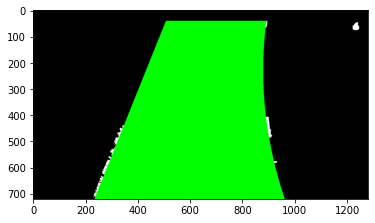

In [ ]:
test_lane_line_Detection_image = detect_lane_lines(test_thresholded_image)
plt.imshow(test_lane_line_Detection_image)

# (5) Pipeline 

In [ ]:
from docopt import docopt
from moviepy.editor import VideoFileClip
from IPython.core.display import Video

In [ ]:
def pipeline(input_frame):
  height, width = 1080, 1920
  FinalScreen = np.zeros((height, width, 3), dtype=np.uint8)
  out_img = np.copy(input_frame)
  
  undistoted_frame = undistort(input_frame)
  cv2.putText(undistoted_frame, 'Undistorted Frame',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
  FinalScreen[0:360,1280:1920] = cv2.resize(undistoted_frame, (640,360), interpolation=cv2.INTER_AREA)

  bird_view_frame = get_eye_bird_view(undistoted_frame)
  cv2.putText(bird_view_frame, 'Bird Eye View Frame',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
  FinalScreen[360:720,1280:1920] = cv2.resize(bird_view_frame, (640,360), interpolation=cv2.INTER_AREA)

  threshold_frame = thresholding(bird_view_frame)
  thresholded_frame_cpy = np.copy(threshold_frame)
  thresholded_frame_cpy = np.dstack((thresholded_frame_cpy, thresholded_frame_cpy, thresholded_frame_cpy))
  cv2.putText(thresholded_frame_cpy, 'Thresholded Frame',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
  FinalScreen[720:1080,1280:1920] = cv2.resize(thresholded_frame_cpy, (640,360), interpolation=cv2.INTER_AREA)

  lane_line_frame = detect_lane_lines(threshold_frame)
  cv2.putText(lane_line_frame, 'Detected Lane Lines Frame',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
  FinalScreen[720:1080,640:1280] = cv2.resize(lane_line_frame, (640,360), interpolation=cv2.INTER_AREA)

  front_view_frame = get_front_view(lane_line_frame)
  cv2.putText(front_view_frame, 'Front view Frame',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
  FinalScreen[720:1080,0:640] = cv2.resize(front_view_frame, (640,360), interpolation=cv2.INTER_AREA)



  out_img = cv2.addWeighted(out_img, 1, front_view_frame, 0.6, 0)
  out_img = plot(out_img)
  cv2.putText(out_img, 'final Frame',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
  FinalScreen[0:720,0:1280] = cv2.resize(out_img, (1280,720), interpolation=cv2.INTER_AREA)
  
  return FinalScreen 

In [ ]:
def process_video(input_path, output_path):
    clip = VideoFileClip(input_path)
    out_clip = clip.fl_image(pipeline)
    out_clip.write_videofile(output_path, audio=False)

### lets now test the pipeline on a video

In [ ]:
process_video('/content/Advanced-Lane-Detetction-phase-1/challenge_video.mp4' , 'outv4.mp4')

[MoviePy] >>>> Building video outv4.mp4
[MoviePy] Writing video outv4.mp4


100%|██████████| 485/485 [01:40<00:00,  4.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: outv4.mp4 

